In [2]:
import NotebookImport
from Imports import *

importing IPython notebook from Imports

In [3]:
cd ../DX/Notebooks/

/cellar/users/agross/TCGA_Code/DX/Notebooks


In [4]:
from Imports import *
from Preprocessing.ClinicalDataFilters import *

importing IPython notebook from Preprocessing/ClinicalDataFilters

importing IPython notebook from Preprocessing/ClinicalData

PCPG
UCS
TGCT
CHOL
THYM
MESO
FPPP


/cellar/users/agross/anaconda2/lib/python2.7/site-packages/Processing/ProcessClinicalDataPortal.py:37: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  f['vitalstatus'] = f['daystodeath'].isnull()


In [5]:
def plot_HR(ci, colors=None, ax=None):
    _, ax = init_ax(ax)
    if colors is None:
        colors = ['grey'] * ci.shape[0]
    ci = np.log2(ci)
    for i,(h,v) in enumerate(ci.iterrows()):
        ax.scatter(v['exp(coef)'], i, marker='s', s=100, color=colors[i], 
                   edgecolors=['black'], zorder=10)
        ax.plot((v['lower .95'],v['upper .95']), (i,i), 
                    lw=3, ls='-', marker='o', dash_joinstyle='bevel', 
                color=colors[i])
    prettify_ax(ax)
    ax.set_ybound(-.5, i + .5)
    ax.set_yticks(range(i+1))
    ax.set_yticklabels(ci.index)
    ax.axvline(0, ls='--', lw=2, color='grey', zorder=-1)
    ax.set_xticklabels(2.**ax.get_xticks())

In [6]:
matched_meth = pd.read_hdf('/data_ssd/TCGA_methylation_2015_04_02.h5', 'matched_tn')

In [7]:
dx_meth = binomial_test_screen(matched_meth, fc=1.)
dx_meth = dx_meth[dx_meth.num_dx > 300]

Median probe methylation level

In [8]:
mm = matched_meth.xs('11',1,1).median(1)
tt = matched_meth.xs('01',1,1).median(1)
dd = (matched_meth.xs('01',1,1) - matched_meth.xs('11',1,1)).median()

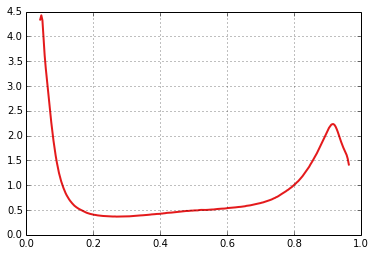

In [9]:
draw_dist(tt)

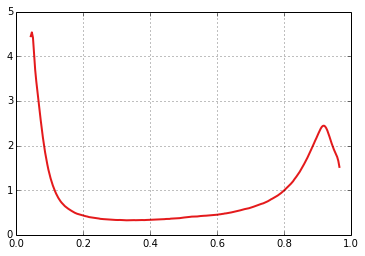

In [10]:
draw_dist(mm)

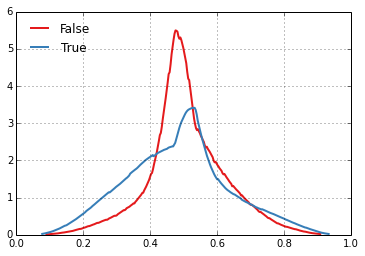

In [11]:
a,b = match_series(dx_meth.frac, mm)
disordered = (a > .5) == (b < .5)
draw_dist(dx_meth.frac, disordered)

In [12]:
fisher_exact_test(dx_meth.frac > .5, mm < .5)

odds_ratio    2.26
p             0.00
dtype: float64

In [13]:
disordered.value_counts()

True     237436
False    158620
dtype: int64

In [14]:
import MethylTools.Probe_Annotations as DX

importing IPython notebook from /cellar/users/agross/anaconda2/lib/python2.7/site-packages/MethylTools/Probe_Annotations

In [15]:
def fig_1g(f, ax):
    lw = 2.5
    draw_dist(f.ix[ti(DX.probe_sets['Promoter'])].dropna(), ax=ax, lw=lw)
    draw_dist(f.ix[ti(DX.probe_sets['CpG Island'])].dropna(), ax=ax, lw=lw)
    draw_dist(f.ix[ti(DX.probe_sets['PRC2'])].dropna(), ax=ax, lw=lw)
    draw_dist(f, ax=ax, colors='grey', lw=lw)
    ax.set_yticks([])
    ax.set_xticks([0,.5,1])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction with Increased Methylation')
    ax.legend(('Promoter','CpG Island','PRC2','All Probes'))
    prettify_ax(ax)
    return ax

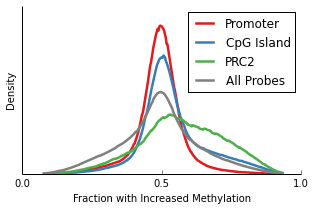

In [16]:
#Do not import
fig, ax = subplots(1,1, figsize=(5,3))
fig_1g(dx_meth.frac, ax);

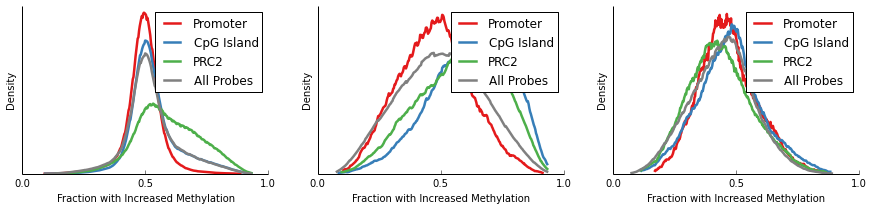

In [17]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,3))
fig_1g(dx_meth.frac.ix[ti(mm < .2)], axs[0]);
fig_1g(dx_meth.frac.ix[ti((mm > .2) & (mm < .8))], axs[1]);
fig_1g(dx_meth.frac.ix[ti(mm > .8)], axs[2]);

In [19]:
ann = DX.probe_annotations
probe_mm = matched_meth.xs('11',1,1).median(1)

In [20]:
pp = ti(DX.cpg_island)
by_gene = dx_meth.frac.dropna().groupby(ann.Gene_Symbol).mean()
gs2 = gene_sets.ix[by_gene.index].fillna(0)

In [21]:
f = dx_meth.frac.ix[ti((probe_mm > .2) & (probe_mm < .8))]
#f = dx_meth.frac
#f = (f - f.mean()) / f.std()
#f = f[(f > .55) | (f < .45)]
#f = dx_meth.frac.ix[ti(disordered == False)]
#f = f.ix[ti(disordered == False)].dropna()
#f = f.ix[ti(DX.cpg_island == True)]
f.shape

(109609,)

In [22]:
s2 = matched_meth.xs('11',1,1).ix[f.index].T.groupby(codes).mean().std()
f = f.ix[ti(s2 < .1)]
f.shape

(49518,)

In [23]:
t = matched_meth['TCGA-05-5420']['01']
n = matched_meth['TCGA-05-5420']['11']

In [24]:
pearson_pandas(f,n)

rho   -0.19
p      0.00
dtype: float64

In [25]:
pearson_pandas(f,t)

rho     1.43e-01
p      2.63e-223
dtype: float64

In [26]:
rr = matched_meth.ix[f.index].corrwith(f - .5)
rr = rr.groupby(level=[0,1]).first()

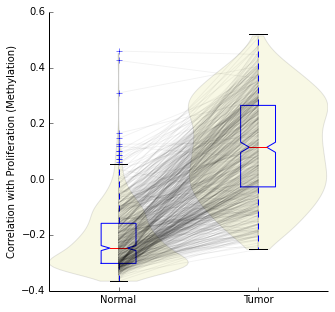

In [27]:
mm = rr.unstack()[['01','11']].dropna().stack()
fig, ax = subplots(figsize=(5,5))
violin_plot_series(mm, ax=ax, order=['11','01'], ann=None)

for i,v in mm.unstack().iterrows():
    ax.plot([0,1],[v['11'], v['01']], color='black', alpha=.05)
ax.set_ylabel('Correlation with Proliferation (Methylation)')
ax.set_xlabel('')
ax.set_xticklabels(['Normal','Tumor'])
prettify_ax(ax)

In [28]:
mm = rr.unstack()[['01','11']].dropna().stack()
((mm[:, '01'] - mm[:, '11']) > 0).value_counts()

True     618
False     11
dtype: int64

In [29]:
mm = matched_meth.xs('11',1,1).ix[f.index].mean(1).ix[f.index]
ss = matched_meth.xs('11',1,1).ix[f.index].std(1).ix[f.index]

In [30]:
store = pd.HDFStore('/data_ssd/TCGA_methylation_2015_04_02.h5')
meth_s = {}
for c in store.keys():
    if c in ['/matched_tn','/codes']:
        continue
    df = store[c].ix[f.index]
    df = df.sub(mm, axis=0).div(ss, axis=0)
    meth_s[c] = df.corrwith(f)
meth_s = pd.concat(meth_s)
meth_s.index = meth_s.index.droplevel(0)
meth_s = meth_s.groupby(level=[0,1]).first()
rp = meth_s.dropna()

In [31]:
import seaborn as sns

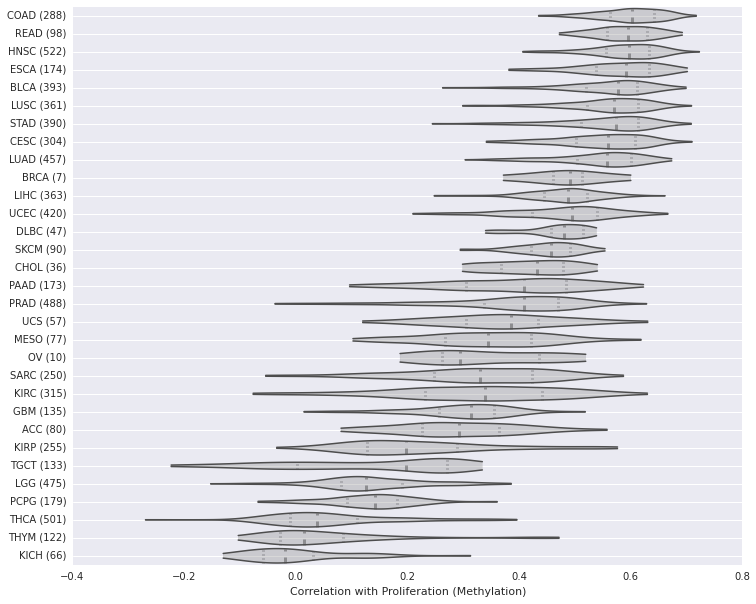

In [32]:
fig, ax = subplots(figsize=(12,10))
zscore = lambda s: (s - s.mean()) / s.std()
vv= rp[:,'01']
z = vv.groupby(codes).apply(zscore)
v2 = vv[z.abs() < 3]
o = v2.groupby(codes).mean().order().index
labels = vv.groupby(codes).size().ix[o]
labels = ['{} ({})'.format(i,v) for i,v in labels.iteritems()]
sns.violinplot(v2, groupby=codes, vert=False,
               bw='scott', cut=0, 
               order=o,
               color='grey', alpha=.3,
               inner_kws={'lw':3, 'alpha':1,'color':'black'},
               names=labels)
ax.set_xlabel('Correlation with Proliferation (Methylation)')
sns.despine(fig)

In [33]:
f = rp[:, '01'].copy()
f = (f - f.mean()) / f.std()
m = get_cox_ph(surv_5y, f, [codes, stage, old, age], print_desc=False, interactions=False)
ci = convert_robj(robjects.r.summary(m)[7])
ci.index = ci.index.map(lambda s: s.replace('codes', ''))
ci.index = ci.index.map(lambda s: s.replace('stagestage', 'stage'))
ci = ci[ci.index != ['BRCA']]
ci = ci[ci.index != ['stage_is']]
pancan_ci = ci.ix['feature']
pancan_ci.name = 'PANCAN'

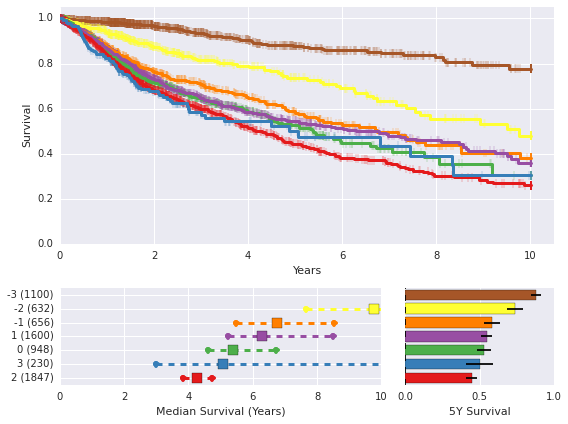

In [34]:
v = rp.ix[:, '01'].dropna()
survival_and_stats(np.round(((v - v.mean()) / v.std()) * 2).clip(-3,3), surv_10y,
                   figsize=(8,6), upper_lim=10)

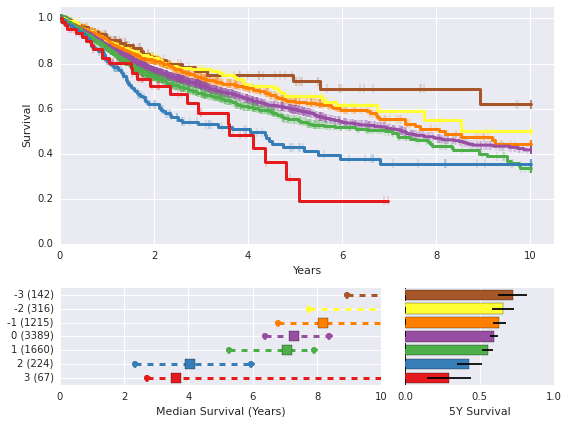

In [35]:
v = rp.ix[:, '01'].dropna()
v = v - codes.map(v.groupby(codes).median())
survival_and_stats(np.round((v - v.mean()) / v.std()).clip(-3,3), surv_10y,
                   figsize=(8,6), upper_lim=10)

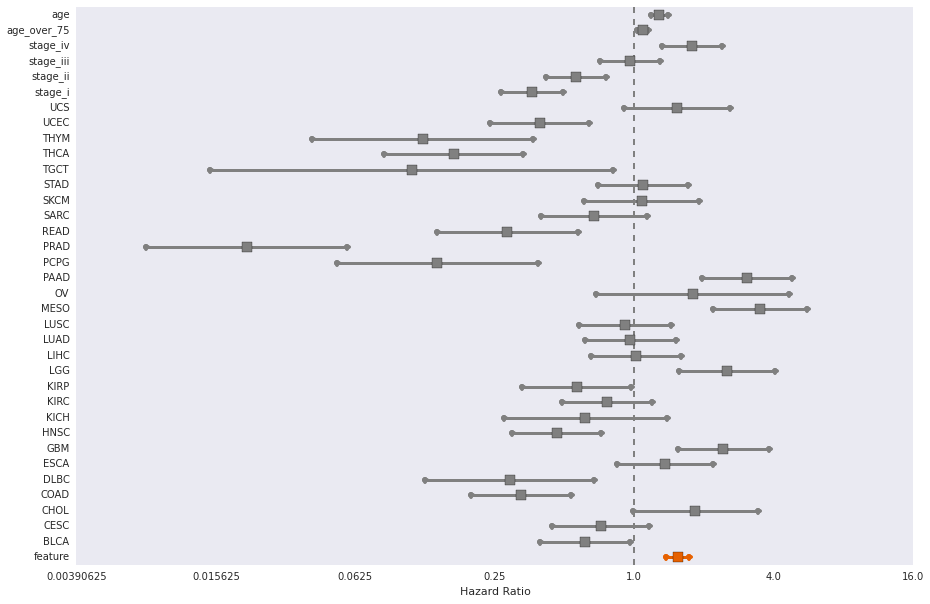

In [36]:
fig, ax = subplots(figsize=(15,10))
colors= ['#E66101'] + (['grey'] * (ci.shape[0] - 1))
plot_HR(ci, ax=ax, colors=colors)
ax.set_xlabel('Hazard Ratio')

In [37]:
v = rp[:, '01'].dropna()
ci = {}
for c in codes.unique():
    try:
        pts = ti(codes == c)
        f = v.ix[pts].dropna()
        cov = [b.ix[pts].dropna() for b in [old, age] if 
               b.ix[pts].dropna().unique().shape[0] > 1]
        f = (f - f.mean()) / f.std()
        f.name = 'featue'
        ff = ' + '.join(['feature'] + [b.name for b in cov])
        formula = robjects.Formula('Surv(days, event) ~ ' + ff)
        m1 = get_cox_ph(surv_5y, f, covariates=cov, formula=formula,
                        print_desc=False, interactions=False);
        ci[c] = convert_robj(robjects.r.summary(m1)[7])
    except:
        print c
cc = pd.concat(ci).xs('feature', level=1)
cc = cc.sort('exp(coef)', ascending=False)
cc = cc[(cc['upper .95'] - cc['lower .95']) < 4]

LAML
BRCA


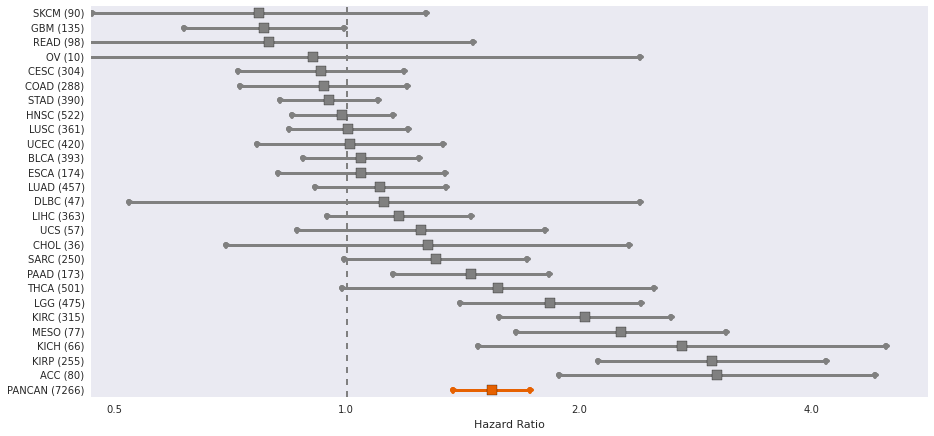

In [38]:
fig, ax = subplots(figsize=(15,7))
c2 = pd.DataFrame([pancan_ci]).append(cc)
colors = ['#E66101'] + (['grey'] * len(cc))
plot_HR(c2, ax=ax, colors=colors)
ax.set_xlim(-1.1, 2.5)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels(2.**ax.get_xticks())
codes_f = codes.ix[(codes.index.intersection(v.index).intersection(stage.index).
                    intersection(age.index).intersection(old.index))]
label = ['{} ({})'.format(i,c) for i,c in 
         codes_f.value_counts().ix[cc.index].iteritems()]
label = ['PANCAN ({})'.format(len(codes_f))] + label
ax.set_yticklabels(label);
ax.set_xlabel('Hazard Ratio')

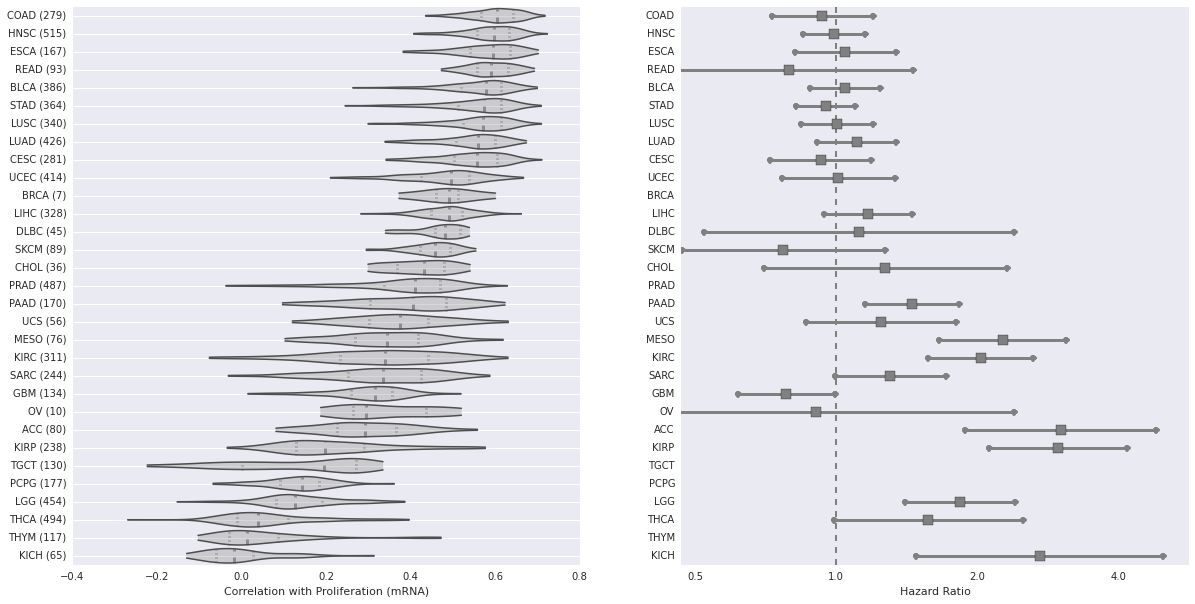

In [39]:
fig, axs = subplots(1, 2, figsize=(20,10))
ax = axs[0]
zscore = lambda s: (s - s.mean()) / s.std()
vv= rp[:,'01'].ix[surv_5y.unstack().index].dropna()
z = vv.groupby(codes).apply(zscore)
v2 = vv[z.abs() < 3]
o = v2.groupby(codes).median().order().index
labels = vv.groupby(codes).size().ix[o]
labels = ['{} ({})'.format(i,v) for i,v in labels.iteritems()]
sns.violinplot(v2, groupby=codes, vert=False,
               bw='scott', cut=0, 
               order=o,
               color='grey', alpha=.3,
               inner_kws={'lw':3, 'alpha':1,'color':'black'},
               names=labels,
               ax=axs[0])
ax.set_xlabel('Correlation with Proliferation (mRNA)')

ax = axs[1]
c2 = pd.DataFrame([pancan_ci]).append(cc)
colors = ['#E66101'] + (['grey'] * len(cc))
plot_HR(c2.ix[o], ax=ax)
ax.set_xlim(-1.1, 2.5)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels(2.**ax.get_xticks())
ax.set_xlabel('Hazard Ratio')

sns.despine(fig)

In [40]:
spearman_pandas(vv.groupby(codes).median(), cc['exp(coef)'])

rho   -6.11e-01
p      9.16e-04
dtype: float64

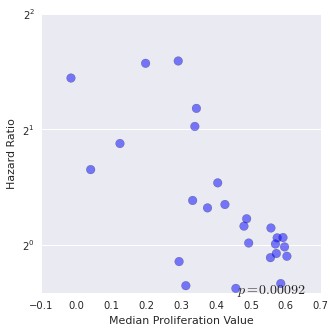

In [41]:
fig, ax = subplots(figsize=(5,5))
cc = pd.concat(ci).xs('feature', level=1)
cc = cc[(cc['upper .95'] - cc['lower .95']) < 4]
v = rp[:,'01'].ix[surv_5y.unstack().index].dropna()
series_scatter(v.groupby(codes).median(), cc['exp(coef)'],
              ax=ax, ann='fancy_p')
prettify_ax(ax)
ax.set_yscale('log', basey=2)
ax.set_ylim(.75,4.)
ax.set_xlabel('Median Proliferation Value')
ax.set_ylabel('Hazard Ratio')

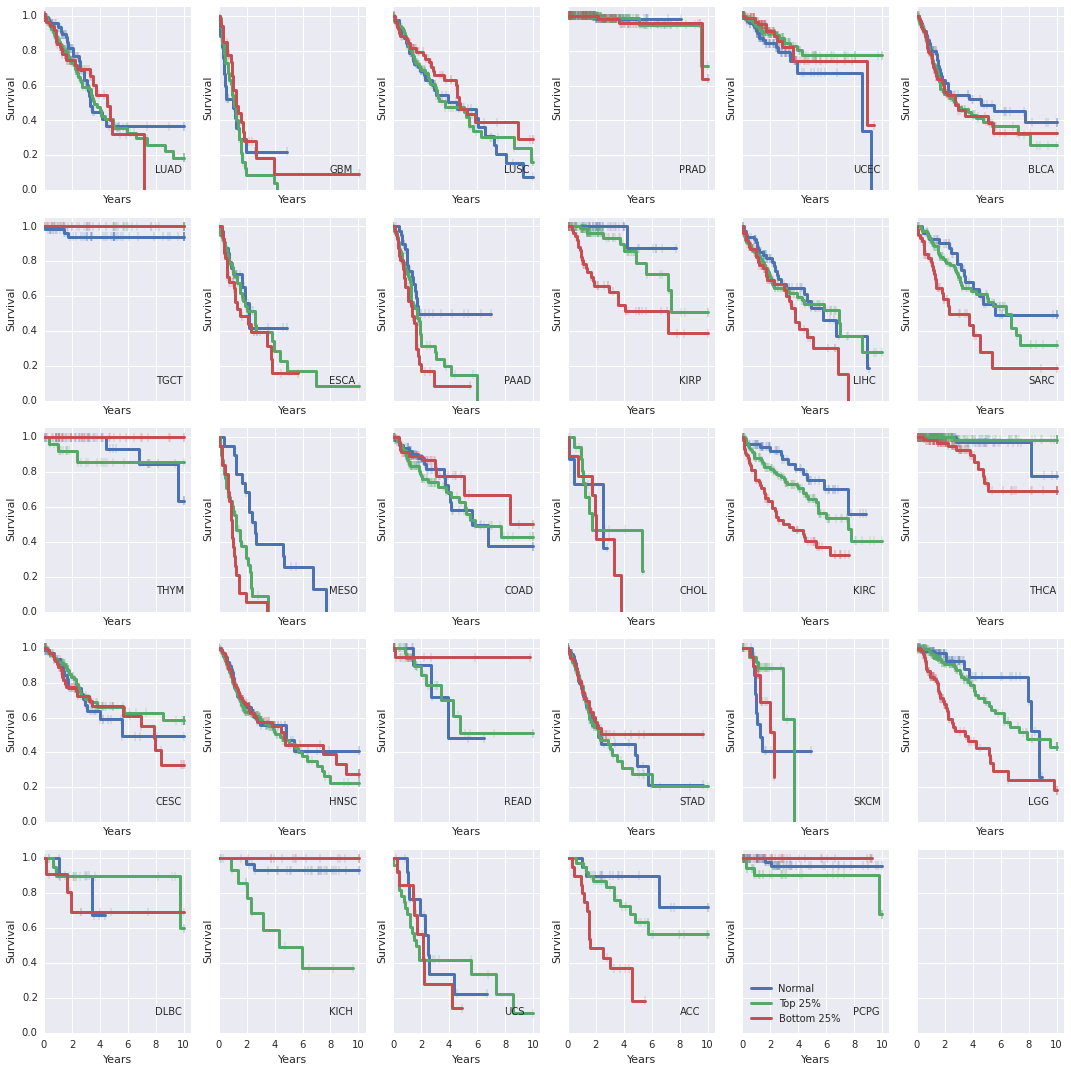

In [42]:
cc = codes.ix[v.index].dropna()
ss = surv_10y.unstack().index
cc = cc[cc.isin(ti(cc.value_counts()  > 30))]
fig, axs = subplots(5,6, figsize=(15,15), sharey=True, sharex=True)
axs = axs.flatten()
for i,c in enumerate(cc.unique()):
    ax = axs[i]
    ax.annotate(c, (8, .1))
    draw_survival_curve(v.ix[ss].ix[ti(cc==c)].dropna(), surv_10y,
                        ax=ax)
    ax.legend_.set_visible(False)
ax.legend_.set_visible(True)
fig.tight_layout()
sns.despine(fig)

In [43]:
v = rp.ix[:, '01'].dropna()
v = v - codes.map(v.groupby(codes).median())
v = v.dropna()
v.name = 'f'

In [44]:
get_cox_ph_ms(surv_5y, v, [codes, stage, old, age], interactions=False)

LR                                                    3.46e-14
feature_p                                              1.3e-13
fmla         Surv(days, event) ~ feature + codes + stage + ...
hazzard                                                   7.98
dtype: object

In [45]:
get_cox_ph_ms(surv_5y, v, [codes, old, age], interactions=False)

LR                                                    1.25e-17
feature_p                                                    0
fmla         Surv(days, event) ~ feature + codes + age_over...
hazzard                                                   10.5
dtype: object

In [46]:
get_cox_ph_ms(surv_5y, v.ix[keepers], [codes, stage, old, age], interactions=False)

LR                                                    3.95e-08
feature_p                                             8.78e-08
fmla         Surv(days, event) ~ feature + codes + stage + ...
hazzard                                                   5.85
dtype: object

In [47]:
rna_sig = pd.read_csv('/cellar/users/agross/TCGA_Code/DX/rna_signature.csv',
                      index_col=[0,1], header=None, squeeze=True)

In [48]:
a,b = match_series(rna_sig[:,1].dropna(), rp[:,'01'].dropna())
codes.ix[a.index].value_counts().head()

HNSC    514
THCA    499
PRAD    487
LGG     475
LUAD    453
dtype: int64

In [51]:
import seaborn as sns
sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

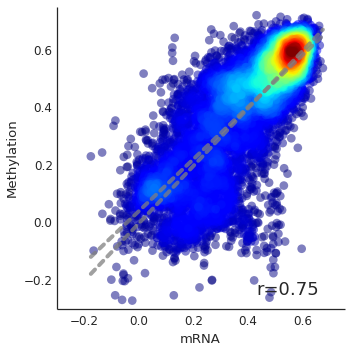

In [56]:
fig, ax = subplots(figsize=(5,5))
plot_regression(rna_sig[:,1], rp[:,'01'], density=True,
                rad=.03, ax=ax)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_xlabel('mRNA')
ax.set_ylabel('Methylation')
fig.tight_layout()
fig.savefig('/cellar/users/agross/Desktop/Figures/rna_vs_meth.png',
            dpi=300)

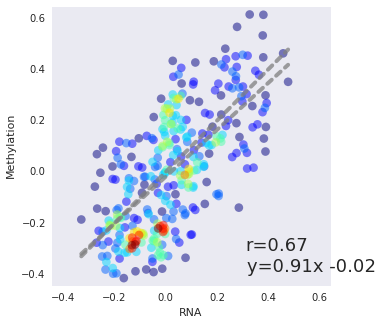

In [1001]:
fig, ax = subplots(figsize=(5,5))
plot_regression(rna_sig[:,11], rp[:,'11'], density=True,
                rad=.03, ax=ax)
ax.set_xlabel('RNA')
ax.set_ylabel('Methylation')

In [1002]:
stanardize = lambda s: (s - s.mean()) / s.std()

In [1003]:
v = (rp.ix[:, '01'] + rna_sig[:,1]).dropna() / 2.
#v = (stanardize(rp.ix[:, '01']) + stanardize(rna_sig[:,1])).dropna() / 2.
a = (rp.ix[:, '01']).groupby(codes).apply(stanardize)
b = (rna_sig[:,1]).groupby(codes).apply(stanardize)
v = ((a + b) / 2).combine_first(a).combine_first(b)
get_cox_ph_ms(surv_5y, v, [codes, old], interactions=False)

LR                                                    1.71e-26
feature_p                                                    0
fmla         Surv(days, event) ~ feature + codes + age_over...
hazzard                                                   1.31
dtype: object

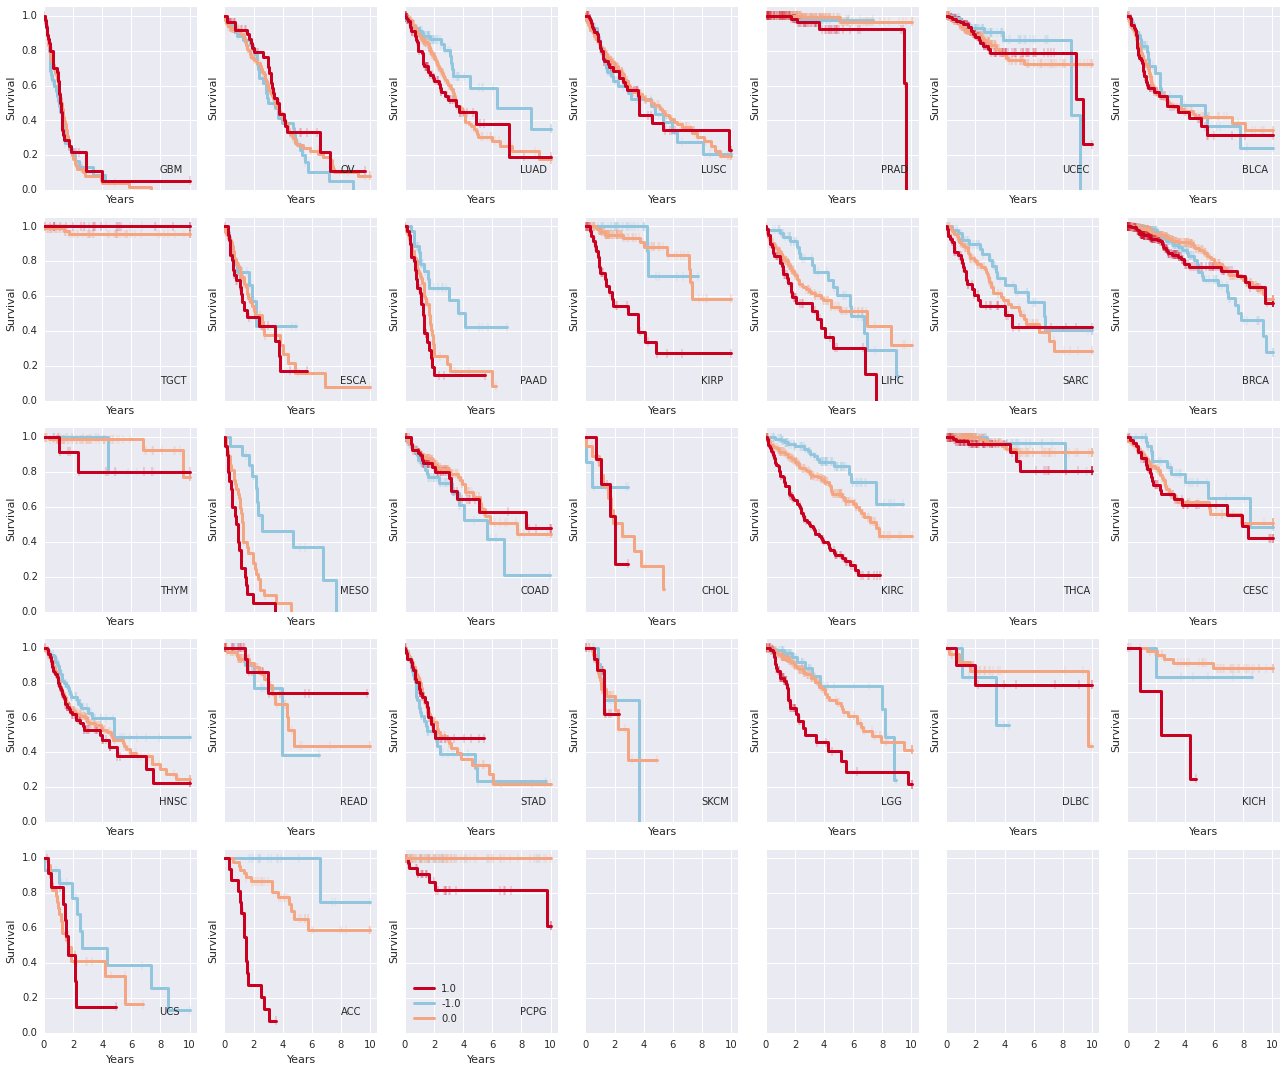

In [1004]:
cc = codes.ix[v.index].dropna()
ss = surv_10y.unstack().index
cc = cc[cc.isin(ti(cc.value_counts()  > 30))]
fig, axs = subplots(5,7, figsize=(18,15), sharey=True, sharex=True)
axs = axs.flatten()
for i,c in enumerate(cc.unique()):
    ax = axs[i]
    ax.annotate(c, (8, .1))
    draw_survival_curve(to_quants(v.ix[ss].ix[ti(cc==c)].dropna(), std=.75), surv_10y,
                        ax=ax, colors={1:colors_st[0], 0:colors_st[1], -1:colors_st[2]})
    ax.legend_.set_visible(False)
ax.legend_.set_visible(True)
fig.tight_layout()
sns.despine(fig)

In [1005]:
get_cox_ph_ms(surv_5y, v, [codes, stage, old], interactions=False)

LR                                                    3.45e-19
feature_p                                                    0
fmla         Surv(days, event) ~ feature + codes + stage + ...
hazzard                                                   1.26
dtype: object

In [1006]:
a = rp.ix[:, '01'] 
b = rna_sig[:,1]
b.name = 'rna'
a.name = 'meth'
get_cox_ph_ms(surv_5y, a, [b, codes, old], interactions=False)

LR                                                    7.05e-07
feature_p                                              9.1e-07
fmla         Surv(days, event) ~ feature + rna + codes + ag...
hazzard                                                   5.37
dtype: object

In [1007]:
a = rp.ix[:, '01'] 
b = rna_sig[:,1]
b.name = 'rna'
a.name = 'meth'
get_cox_ph_ms(surv_5y, b, [a, codes, old], interactions=False)

LR                                                     8.6e-16
feature_p                                                3e-15
fmla         Surv(days, event) ~ feature + meth + codes + a...
hazzard                                                   20.7
dtype: object